In [1]:
# Also added currency data and bond yields since original

In [2]:
import keras
import pandas as pd
import numpy as np
from keras.layers import *
from keras.activations import *
from keras.callbacks import *
from keras.optimizers import *
from keras.models import *
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
import stldecompose

Using TensorFlow backend.


In [3]:
data_orig = pd.read_csv('../data/files/multiple_concatenated_tickers.csv')
data_orig.tail()

Index    QQQ.Open    QQQ.High     QQQ.Low   QQQ.Close  QQQ.Volume  \
986  2019-05-28  178.660004  179.660004  177.470001  177.490005    24763800   
987  2019-05-29  176.389999  177.000000  175.089996  176.029999    42178800   
988  2019-05-30  176.500000  177.270004  175.770004  176.770004    30354800   
989  2019-05-31  174.690002  175.289993  173.869995  173.949997    45446200   
990  2019-06-02    0.000000    0.000000    0.000000    0.000000           0   

     QQQ.Adjusted   TSLA.Open   TSLA.High    TSLA.Low       ...        \
986    177.490005  191.199997  195.000000  187.850006       ...         
987    176.029999  187.100006  192.389999  185.039993       ...         
988    176.770004  188.750000  192.259995  187.020004       ...         
989    173.949997  185.100006  189.919998  184.100006       ...         
990      0.000000    0.000000    0.000000    0.000000       ...         

     ZAR.X.Low  ZAR.X.Close  ZAR.X.Volume  ZAR.X.Adjusted  RUB.X.Open  \
986    14.6831      14.6988             0         14.6988   64.628899   
987    14.5727      14.6291             0         14.6291   64.920898   
988    14.5391      14.7690             0         14.7690   65.234299   
989     0.0000       0.0000             0          0.0000    0.000000   
990    14.4436      14.5997             0         14.5997   65.566002   

     RUB.X.High  RUB.X.Low  RUB.X.Close  RUB.X.Volume  RUB.X.Adjusted  
986   65.362000  64.628899    64.633797             0       64.633797  
987   65.115997  64.851700    64.920799             0       64.920799  
988   65.568001  65.114799    65.213898             0       65.213898  
989    0.000000   0.000000     0.000000             0        0.000000  
990   65.623001  65.157402    65.555199             0       65.555199  

[5 rows x 463 columns]

In [4]:
vol_data_orig = pd.read_csv('../data/files/multiple_concatenated_tickers_volatility.csv')
vol_data_orig.tail()

Index  volatilityQQQ  volatilityTSLA  volatilityMSFT  \
986  2019-05-28       0.183852        0.483588        0.186742   
987  2019-05-29       0.158398        0.496305        0.186286   
988  2019-05-30       0.143673        0.500744        0.130547   
989  2019-05-31       0.153630        0.361541        0.149190   
990  2019-06-02       0.000000        0.000000        0.000000   

     volatilityINTC  volatilityAAPL  volatilityNFLX  volatilityAMZN  \
986        0.270302        0.252418        0.274788        0.238321   
987        0.280098        0.228010        0.250764        0.218519   
988        0.291132        0.238717        0.243699        0.173038   
989        0.293111        0.245777        0.266478        0.180578   
990        0.000000        0.000000        0.000000        0.000000   

     volatilityFB  volatilityGOOG       ...         volatilityHKD=X  \
986      0.267943        0.282097       ...                0.000890   
987      0.214788        0.184619       ...                0.000815   
988      0.215419        0.158455       ...                0.001110   
989      0.263393        0.156286       ...                0.000000   
990      0.000000        0.000000       ...                0.007387   

     volatilitySGD=X  volatilityINR=X  volatilityMXN=X  volatilityPHP=X  \
986         0.031800         0.059171         0.051220         0.063646   
987         0.029436         0.058933         0.053181         0.062625   
988         0.026340         0.060854         0.120192         0.065437   
989         0.000000         0.000000         0.000000         0.000000   
990         0.035891         0.067138         0.113475         0.064756   

     volatilityIDR=X  volatilityTHB=X  volatilityMYR=X  volatilityZAR=X  \
986         0.069873         0.038216         0.021162         0.120958   
987         0.071967         0.038598         0.017874         0.128730   
988         0.056776         0.025846         0.020876         0.128322   
989         0.000000         0.000000         0.000000         0.000000   
990         0.074031         0.049270         0.021563         0.147066   

     volatilityRUB=X  
986         0.064795  
987         0.068993  
988         0.072307  
989         0.000000  
990         0.070317  

[5 rows x 78 columns]

In [5]:
data_orig = data_orig\
  .merge(vol_data_orig, how="inner", left_on=data_orig.Index, right_on=vol_data_orig.Index).fillna(method="ffill")\
  .drop(["key_0", "Index_y"], axis=1)\
  .rename(columns={'Index_x':'Index'})

In [6]:
list(data_orig.columns)

['Index',
 'QQQ.Open',
 'QQQ.High',
 'QQQ.Low',
 'QQQ.Close',
 'QQQ.Volume',
 'QQQ.Adjusted',
 'TSLA.Open',
 'TSLA.High',
 'TSLA.Low',
 'TSLA.Close',
 'TSLA.Volume',
 'TSLA.Adjusted',
 'MSFT.Open',
 'MSFT.High',
 'MSFT.Low',
 'MSFT.Close',
 'MSFT.Volume',
 'MSFT.Adjusted',
 'INTC.Open',
 'INTC.High',
 'INTC.Low',
 'INTC.Close',
 'INTC.Volume',
 'INTC.Adjusted',
 'AAPL.Open',
 'AAPL.High',
 'AAPL.Low',
 'AAPL.Close',
 'AAPL.Volume',
 'AAPL.Adjusted',
 'NFLX.Open',
 'NFLX.High',
 'NFLX.Low',
 'NFLX.Close',
 'NFLX.Volume',
 'NFLX.Adjusted',
 'AMZN.Open',
 'AMZN.High',
 'AMZN.Low',
 'AMZN.Close',
 'AMZN.Volume',
 'AMZN.Adjusted',
 'FB.Open',
 'FB.High',
 'FB.Low',
 'FB.Close',
 'FB.Volume',
 'FB.Adjusted',
 'GOOG.Open',
 'GOOG.High',
 'GOOG.Low',
 'GOOG.Close',
 'GOOG.Volume',
 'GOOG.Adjusted',
 'SQ.Open',
 'SQ.High',
 'SQ.Low',
 'SQ.Close',
 'SQ.Volume',
 'SQ.Adjusted',
 'TWTR.Open',
 'TWTR.High',
 'TWTR.Low',
 'TWTR.Close',
 'TWTR.Volume',
 'TWTR.Adjusted',
 'DATA.Open',
 'DATA.High',
 '

In [7]:
from urllib.request import *
from io import StringIO
import pandas as pd

def df_from_fred(setname):
    # Make GET Request
    response = urlopen(url_for(setname))
    # Read response data
    data = response.read()
    # Convert binary text to utf-8
    text = data.decode('utf-8')
    # Convert text file to pandas dataframe
    TEXTDATA = StringIO(text)
    df = pd.read_csv(TEXTDATA, sep=",")
    return df

def url_for(series):
    """function takes FRED series name as input. For example, GDPC1, or HOUST."""
    return "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=968&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id="+series+"&scale=left&cosd=1947-01-01&coed=2019-01-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Quarterly&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2019-05-07&revision_date=2019-05-07&nd=1947-01-01"


In [8]:
# Vital Economic indicators: https://gist.github.com/ngopal/262fce10a7fa4a8467f0c61a13c85dc5
GDPC1 = df_from_fred("GDPC1")
time.sleep(5)
M2 = df_from_fred("M2")
time.sleep(5)
CPALTT01USQ657N = df_from_fred("CPALTT01USQ657N")
time.sleep(5)
PPIACO = df_from_fred("PPIACO")
time.sleep(5)
UMCSENT = df_from_fred("UMCSENT")
time.sleep(5)
PAYEMS = df_from_fred("PAYEMS")
time.sleep(5)
RRSFS = df_from_fred("RRSFS")
time.sleep(5)
HOUST = df_from_fred("HOUST")
time.sleep(5)
ISRATIO = df_from_fred("ISRATIO")
time.sleep(5)
SP500 = df_from_fred("SP500")
time.sleep(5)

# Thoughts
FEDFUNDS = df_from_fred("FEDFUNDS")
time.sleep(5)
UNRATE = df_from_fred("UNRATE")
time.sleep(5)
T10Y2Y = df_from_fred("T10Y2Y")
time.sleep(5)
CBBTCUSD = df_from_fred("CBBTCUSD")
time.sleep(5)

# Others
IPMAN = df_from_fred("IPMAN")
time.sleep(5)
MPU9900063 = df_from_fred("MPU9900063")
time.sleep(5)
PCU33443344 = df_from_fred("PCU33443344")
time.sleep(5)
MEHOINUSA672N = df_from_fred("MEHOINUSA672N")
time.sleep(5)
TCMDO = df_from_fred("TCMDO")
time.sleep(5)
FGTCMDODNS = df_from_fred("FGTCMDODNS")
time.sleep(5)
ADSLFAA027N = df_from_fred("ADSLFAA027N")
time.sleep(5)
NCBCMDPMVCE = df_from_fred("NCBCMDPMVCE")
time.sleep(5)
FGCCSAQ027S = df_from_fred("FGCCSAQ027S")
time.sleep(5)
ASTNITA = df_from_fred("ASTNITA")
time.sleep(5)
PCETRIM12M159SFRBDAL = df_from_fred("PCETRIM12M159SFRBDAL")
DAAA = df_from_fred("DAAA")
time.sleep(5)
USSLIND = df_from_fred("USSLIND")
time.sleep(5)
IRLTLT01USM156N = df_from_fred("IRLTLT01USM156N")
time.sleep(5)

# IPMAN, MPU9900063, PCU33443344, MEHOINUSA672N, TCMDO, FGTCMDODNS, ADSLFAA027N, NCBCMDPMVCE, FGCCSAQ027S, ASTNITA

In [9]:
data_orig = data_orig\
  .merge(GDPC1, how="left", left_on=data_orig.Index, right_on=GDPC1.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(M2, how="left", left_on=data_orig.Index, right_on=M2.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(CPALTT01USQ657N, how="left", left_on=data_orig.Index, right_on=CPALTT01USQ657N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PPIACO, how="left", left_on=data_orig.Index, right_on=PPIACO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(UMCSENT, how="left", left_on=data_orig.Index, right_on=UMCSENT.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PAYEMS, how="left", left_on=data_orig.Index, right_on=PAYEMS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(RRSFS, how="left", left_on=data_orig.Index, right_on=RRSFS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(HOUST, how="left", left_on=data_orig.Index, right_on=HOUST.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ISRATIO, how="left", left_on=data_orig.Index, right_on=ISRATIO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PCETRIM12M159SFRBDAL, how="left", left_on=data_orig.Index, right_on=PCETRIM12M159SFRBDAL.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ASTNITA, how="left", left_on=data_orig.Index, right_on=ASTNITA.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FGCCSAQ027S, how="left", left_on=data_orig.Index, right_on=FGCCSAQ027S.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(NCBCMDPMVCE, how="left", left_on=data_orig.Index, right_on=NCBCMDPMVCE.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ADSLFAA027N, how="left", left_on=data_orig.Index, right_on=ADSLFAA027N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FGTCMDODNS, how="left", left_on=data_orig.Index, right_on=FGTCMDODNS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(TCMDO, how="left", left_on=data_orig.Index, right_on=TCMDO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(MEHOINUSA672N, how="left", left_on=data_orig.Index, right_on=MEHOINUSA672N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PCU33443344, how="left", left_on=data_orig.Index, right_on=PCU33443344.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(MPU9900063, how="left", left_on=data_orig.Index, right_on=MPU9900063.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(IPMAN, how="left", left_on=data_orig.Index, right_on=IPMAN.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(SP500, how="left", left_on=data_orig.Index, right_on=SP500.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FEDFUNDS, how="left", left_on=data_orig.Index, right_on=FEDFUNDS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(UNRATE, how="left", left_on=data_orig.Index, right_on=UNRATE.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(T10Y2Y, how="left", left_on=data_orig.Index, right_on=T10Y2Y.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(CBBTCUSD, how="left", left_on=data_orig.Index, right_on=CBBTCUSD.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(DAAA, how="left", left_on=data_orig.Index, right_on=DAAA.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(USSLIND, how="left", left_on=data_orig.Index, right_on=USSLIND.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(IRLTLT01USM156N, how="left", left_on=data_orig.Index, right_on=IRLTLT01USM156N.DATE).fillna(method="ffill")\
  .fillna(-1)

In [10]:
data_orig.drop(['DATE_y', 'DATE_x', 'key_0'], axis=1, inplace=True)

In [11]:
list(data_orig.columns)

['Index',
 'QQQ.Open',
 'QQQ.High',
 'QQQ.Low',
 'QQQ.Close',
 'QQQ.Volume',
 'QQQ.Adjusted',
 'TSLA.Open',
 'TSLA.High',
 'TSLA.Low',
 'TSLA.Close',
 'TSLA.Volume',
 'TSLA.Adjusted',
 'MSFT.Open',
 'MSFT.High',
 'MSFT.Low',
 'MSFT.Close',
 'MSFT.Volume',
 'MSFT.Adjusted',
 'INTC.Open',
 'INTC.High',
 'INTC.Low',
 'INTC.Close',
 'INTC.Volume',
 'INTC.Adjusted',
 'AAPL.Open',
 'AAPL.High',
 'AAPL.Low',
 'AAPL.Close',
 'AAPL.Volume',
 'AAPL.Adjusted',
 'NFLX.Open',
 'NFLX.High',
 'NFLX.Low',
 'NFLX.Close',
 'NFLX.Volume',
 'NFLX.Adjusted',
 'AMZN.Open',
 'AMZN.High',
 'AMZN.Low',
 'AMZN.Close',
 'AMZN.Volume',
 'AMZN.Adjusted',
 'FB.Open',
 'FB.High',
 'FB.Low',
 'FB.Close',
 'FB.Volume',
 'FB.Adjusted',
 'GOOG.Open',
 'GOOG.High',
 'GOOG.Low',
 'GOOG.Close',
 'GOOG.Volume',
 'GOOG.Adjusted',
 'SQ.Open',
 'SQ.High',
 'SQ.Low',
 'SQ.Close',
 'SQ.Volume',
 'SQ.Adjusted',
 'TWTR.Open',
 'TWTR.High',
 'TWTR.Low',
 'TWTR.Close',
 'TWTR.Volume',
 'TWTR.Adjusted',
 'DATA.Open',
 'DATA.High',
 '

In [12]:
ticker_lookup = dict([(i[1].split('.')[0], int(i[0])) for i in enumerate(list(data_orig.columns)) if (('Open' in i[1]) or ("volatility" in i[1]))])
ticker_lookup

{'AAPL': 25,
 'AMD': 73,
 'AMZN': 37,
 'AUDUSD': 343,
 'BABA': 193,
 'BP': 199,
 'BTCUSD': 313,
 'BUD': 205,
 'CNY': 397,
 'DATA': 67,
 'DIS': 151,
 'DUK': 163,
 'ETHUSD': 319,
 'EURCAD': 373,
 'EURCHF': 385,
 'EURGBP': 367,
 'EURHUF': 391,
 'EURJPY': 355,
 'EURSEK': 379,
 'EURUSD': 325,
 'FB': 43,
 'GBPJPY': 361,
 'GBPUSD': 337,
 'GLD': 181,
 'GLW': 211,
 'GOOG': 49,
 'HD': 157,
 'HKD': 403,
 'IDR': 433,
 'INR': 415,
 'INTC': 19,
 'JNJ': 109,
 'JPY': 331,
 'JWN': 97,
 'KO': 115,
 'MSFT': 13,
 'MXN': 421,
 'MYR': 445,
 'NFLX': 31,
 'NVDA': 133,
 'NZDUSD': 349,
 'PANW': 127,
 'PFE': 217,
 'PG': 103,
 'PHP': 427,
 'QQQ': 1,
 'RHT': 139,
 'RUB': 457,
 'SBUX': 79,
 'SFIX': 223,
 'SGD': 409,
 'SLV': 187,
 'SPOT': 169,
 'SQ': 55,
 'STX': 229,
 'T': 235,
 'TGT': 91,
 'THB': 439,
 'TSLA': 7,
 'TWTR': 61,
 'USO': 145,
 'V': 241,
 'VRSN': 121,
 'WDC': 175,
 'WMT': 85,
 'XLB': 253,
 'XLE': 247,
 'XLF': 283,
 'XLI': 259,
 'XLK': 289,
 'XLP': 271,
 'XLRE': 307,
 'XLU': 301,
 'XLV': 277,
 'XLY': 265

In [13]:
data_orig.iloc[:,1:].shift(1)

QQQ.Open    QQQ.High     QQQ.Low   QQQ.Close  QQQ.Volume  QQQ.Adjusted  \
0           NaN         NaN         NaN         NaN         NaN           NaN   
1      0.000000    0.000000    0.000000    0.000000         0.0      0.000000   
2    109.449997  109.599998  108.120003  109.500000  50807600.0    106.223091   
3    110.040001  110.180000  108.800003  109.309998  38795200.0    106.038773   
4    107.410004  108.889999  107.410004  108.260002  41891100.0    105.020172   
5    105.949997  107.290001  104.809998  104.870003  61386300.0    101.731651   
6    105.629997  106.290001  103.900002  104.010002  69344000.0    100.897369   
7    104.750000  105.059998  102.730003  104.330002  49767900.0    101.207802   
8    105.330002  106.080002  104.080002  105.540001  46734200.0    102.381592   
9    105.970001  106.230003  101.739998  101.900002  69870700.0     98.850510   
10   102.300003  104.980003  100.669998  104.070000  78445700.0    100.955582   
11   100.620003  101.940002   99.510002  100.839996  91443900.0     97.822235   
12     0.000000    0.000000    0.000000    0.000000         0.0      0.000000   
13   102.209999  102.370003   99.879997  101.059998  56563800.0     98.035660   
14    99.470001  101.830002   97.250000  100.750000  86675000.0     97.734932   
15   101.180000  102.349998   99.820000  100.849998  61660100.0     97.831940   
16   102.879997  103.809998  102.529999  103.769997  42229800.0    100.664558   
17   103.400002  103.989998  102.139999  102.230003  38437500.0     99.170647   
18   102.650002  103.589996  101.760002  103.150002  34571800.0    100.063103   
19   102.550003  102.989998  100.150002  100.580002  54524700.0     97.570038   
20   102.250000  102.290001  100.260002  102.000000  47641500.0     98.947517   
21   101.970001  104.169998  101.940002  104.129997  54245100.0    101.013786   
22   103.629997  104.800003  103.230003  104.410004  32750300.0    101.285408   
23   103.930000  103.970001  101.839996  102.150002  44928100.0     99.093040   
24   102.830002  102.830002   99.879997  101.660004  61572900.0     98.617706   
25   101.389999  102.459999  100.440002  101.650002  49189100.0     98.608002   
26   101.290001  101.330002   97.720001   98.120003  70749900.0     95.183640   
27    96.290001   97.050003   94.839996   96.620003  91673100.0     93.728523   
28    95.330002   97.779999   95.180000   96.320000  73531500.0     93.437508   
29    97.430000   98.690002   96.620003   96.690002  59421700.0     93.796425   
..          ...         ...         ...         ...         ...           ...   
961    0.000000    0.000000    0.000000    0.000000         0.0      0.000000   
962  190.649994  191.320007  190.339996  191.020004  21716200.0    191.020004   
963  189.479996  189.850006  188.210007  189.539993  31495300.0    189.539993   
964  190.779999  191.320007  188.800003  188.929993  34797100.0    188.929993   
965  188.869995  189.850006  186.869995  188.110001  44110100.0    188.110001   
966  189.669998  191.250000  189.330002  191.110001  30386200.0    191.110001   
967    0.000000    0.000000    0.000000    0.000000         0.0      0.000000   
968  187.050003  190.199997  186.759995  189.940002  38371800.0    189.940002   
969  187.869995  188.669998  184.509995  186.240005  58818100.0    186.240005   
970  185.630005  187.169998  184.960007  185.770004  37165300.0    185.770004   
971  183.699997  185.410004  182.089996  184.770004  55351700.0    184.770004   
972  184.110001  185.889999  181.029999  185.000000  58526400.0    185.000000   
973    0.000000    0.000000    0.000000    0.000000         0.0      0.000000   
974  180.289993  181.259995  178.059998  178.580002  67185800.0    178.580002   
975  179.520004  181.630005  178.860001  180.539993  43360600.0    180.539993   
976  179.350006  183.550003  179.309998  183.089996  40944500.0    183.089996   
977  183.169998  186.070007  182.949997  184.929993  39281200.0    184.929993   
978  183.100006  185.580002  182.88000

In [14]:
days_lookback = 1
pct_df = data_orig.iloc[:,1:].shift(days_lookback).fillna(-1)
pct_df

QQQ.Open    QQQ.High     QQQ.Low   QQQ.Close  QQQ.Volume  QQQ.Adjusted  \
0     -1.000000   -1.000000   -1.000000   -1.000000        -1.0     -1.000000   
1      0.000000    0.000000    0.000000    0.000000         0.0      0.000000   
2    109.449997  109.599998  108.120003  109.500000  50807600.0    106.223091   
3    110.040001  110.180000  108.800003  109.309998  38795200.0    106.038773   
4    107.410004  108.889999  107.410004  108.260002  41891100.0    105.020172   
5    105.949997  107.290001  104.809998  104.870003  61386300.0    101.731651   
6    105.629997  106.290001  103.900002  104.010002  69344000.0    100.897369   
7    104.750000  105.059998  102.730003  104.330002  49767900.0    101.207802   
8    105.330002  106.080002  104.080002  105.540001  46734200.0    102.381592   
9    105.970001  106.230003  101.739998  101.900002  69870700.0     98.850510   
10   102.300003  104.980003  100.669998  104.070000  78445700.0    100.955582   
11   100.620003  101.940002   99.510002  100.839996  91443900.0     97.822235   
12     0.000000    0.000000    0.000000    0.000000         0.0      0.000000   
13   102.209999  102.370003   99.879997  101.059998  56563800.0     98.035660   
14    99.470001  101.830002   97.250000  100.750000  86675000.0     97.734932   
15   101.180000  102.349998   99.820000  100.849998  61660100.0     97.831940   
16   102.879997  103.809998  102.529999  103.769997  42229800.0    100.664558   
17   103.400002  103.989998  102.139999  102.230003  38437500.0     99.170647   
18   102.650002  103.589996  101.760002  103.150002  34571800.0    100.063103   
19   102.550003  102.989998  100.150002  100.580002  54524700.0     97.570038   
20   102.250000  102.290001  100.260002  102.000000  47641500.0     98.947517   
21   101.970001  104.169998  101.940002  104.129997  54245100.0    101.013786   
22   103.629997  104.800003  103.230003  104.410004  32750300.0    101.285408   
23   103.930000  103.970001  101.839996  102.150002  44928100.0     99.093040   
24   102.830002  102.830002   99.879997  101.660004  61572900.0     98.617706   
25   101.389999  102.459999  100.440002  101.650002  49189100.0     98.608002   
26   101.290001  101.330002   97.720001   98.120003  70749900.0     95.183640   
27    96.290001   97.050003   94.839996   96.620003  91673100.0     93.728523   
28    95.330002   97.779999   95.180000   96.320000  73531500.0     93.437508   
29    97.430000   98.690002   96.620003   96.690002  59421700.0     93.796425   
..          ...         ...         ...         ...         ...           ...   
961    0.000000    0.000000    0.000000    0.000000         0.0      0.000000   
962  190.649994  191.320007  190.339996  191.020004  21716200.0    191.020004   
963  189.479996  189.850006  188.210007  189.539993  31495300.0    189.539993   
964  190.779999  191.320007  188.800003  188.929993  34797100.0    188.929993   
965  188.869995  189.850006  186.869995  188.110001  44110100.0    188.110001   
966  189.669998  191.250000  189.330002  191.110001  30386200.0    191.110001   
967    0.000000    0.000000    0.000000    0.000000         0.0      0.000000   
968  187.050003  190.199997  186.759995  189.940002  38371800.0    189.940002   
969  187.869995  188.669998  184.509995  186.240005  58818100.0    186.240005   
970  185.630005  187.169998  184.960007  185.770004  37165300.0    185.770004   
971  183.699997  185.410004  182.089996  184.770004  55351700.0    184.770004   
972  184.110001  185.889999  181.029999  185.000000  58526400.0    185.000000   
973    0.000000    0.000000    0.000000    0.000000         0.0      0.000000   
974  180.289993  181.259995  178.059998  178.580002  67185800.0    178.580002   
975  179.520004  181.630005  178.860001  180.539993  43360600.0    180.539993   
976  179.350006  183.550003  179.309998  183.089996  40944500.0    183.089996   
977  183.169998  186.070007  182.949997  184.929993  39281200.0    184.929993   
978  183.100006  185.580002  182.88000

In [18]:
# data_orig.drop("DATE", axis=1, inplace=True)
# pct_df.drop("DATE", axis=1, inplace=True)
# data_orig.drop("Index", axis=1, inplace=True)
# pct_df.drop("Index", axis=1, inplace=True)

KeyError: "['Index'] not found in axis"

In [19]:
inv_map = {v+'.Open': k for k, v in dict(enumerate(list(ticker_lookup.keys()))).items()}
inv_map

{'AAPL.Open': 4,
 'AMD.Open': 12,
 'AMZN.Open': 6,
 'AUDUSD.Open': 57,
 'BABA.Open': 32,
 'BP.Open': 33,
 'BTCUSD.Open': 52,
 'BUD.Open': 34,
 'CNY.Open': 66,
 'DATA.Open': 11,
 'DIS.Open': 25,
 'DUK.Open': 27,
 'ETHUSD.Open': 53,
 'EURCAD.Open': 62,
 'EURCHF.Open': 64,
 'EURGBP.Open': 61,
 'EURHUF.Open': 65,
 'EURJPY.Open': 59,
 'EURSEK.Open': 63,
 'EURUSD.Open': 54,
 'FB.Open': 7,
 'GBPJPY.Open': 60,
 'GBPUSD.Open': 56,
 'GLD.Open': 30,
 'GLW.Open': 35,
 'GOOG.Open': 8,
 'HD.Open': 26,
 'HKD.Open': 67,
 'IDR.Open': 72,
 'INR.Open': 69,
 'INTC.Open': 3,
 'JNJ.Open': 18,
 'JPY.Open': 55,
 'JWN.Open': 16,
 'KO.Open': 19,
 'MSFT.Open': 2,
 'MXN.Open': 70,
 'MYR.Open': 74,
 'NFLX.Open': 5,
 'NVDA.Open': 22,
 'NZDUSD.Open': 58,
 'PANW.Open': 21,
 'PFE.Open': 36,
 'PG.Open': 17,
 'PHP.Open': 71,
 'QQQ.Open': 0,
 'RHT.Open': 23,
 'RUB.Open': 76,
 'SBUX.Open': 13,
 'SFIX.Open': 37,
 'SGD.Open': 68,
 'SLV.Open': 31,
 'SPOT.Open': 28,
 'SQ.Open': 9,
 'STX.Open': 38,
 'T.Open': 39,
 'TGT.Open': 

In [20]:
# De-trend data
data_orig_detrended = signal.detrend(data_orig)

scaler = MinMaxScaler(feature_range=(0, 1))
# data_mat = scaler.fit_transform(data_orig.iloc[:,1:])
data_mat = scaler.fit_transform(data_orig_detrended)
pctdf_mat = scaler.transform(pct_df)

In [21]:
seq_len = 90 # days to use for prediction
data = np.array((data_mat))

In [22]:
sequence_length = seq_len + 1
result = []
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])

result = np.array(result)

row = round(0.9 * result.shape[0])
train = result[:int(row), :] # Create training set

In [23]:
# np.random.shuffle(train)
x_train = result[:int(row), :]
y_train = pctdf_mat[:int(row)] # Needs to be N-day shift
x_test = result[int(row):, :]
y_test = pctdf_mat[int(row):]  # Needs to be N-day shift

[x_train, y_train, x_test, y_test]

[array([[[0.99819199, 0.99819249, 0.99819299, ..., 0.99277347,
          0.99276327, 0.99275309],
         [0.98774285, 0.98778387, 0.98782471, ..., 0.99282484,
          0.99282312, 0.99282141],
         [0.99128123, 0.99131174, 0.99134211, ..., 0.99363417,
          0.99363024, 0.99362632],
         ...,
         [0.98343799, 0.98348157, 0.98352497, ..., 0.98920443,
          0.98920329, 0.98920214],
         [0.98910908, 0.98914768, 0.98918611, ..., 0.99355925,
          0.99355702, 0.99355479],
         [0.99475108, 0.99479071, 0.99483016, ..., 0.99943467,
          0.99943259, 0.99943051]],
 
        [[0.98774285, 0.98778387, 0.98782471, ..., 0.99282484,
          0.99282312, 0.99282141],
         [0.99128123, 0.99131174, 0.99134211, ..., 0.99363417,
          0.99363024, 0.99362632],
         [0.98984375, 0.98988119, 0.98991847, ..., 0.99399134,
          0.99398885, 0.99398638],
         ...,
         [0.98910908, 0.98914768, 0.98918611, ..., 0.99355925,
          0.99355702, 0.

In [24]:
LAYERS = 30
model = Sequential()

model.add(LSTM(
    input_dim=data.shape[1],
    output_dim=LAYERS,
    return_sequences=True))
# model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(
    LAYERS,
    return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(
    output_dim=y_train.shape[1]))
model.add(Activation('linear'))

start = time.time()
# adam = Adam(lr=0.1)
model.compile(loss='mse', optimizer="adam")
print('compilation time : ', time.time() - start)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 567..., units=30)`
  import sys


compilation time :  0.031117677688598633


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=567)`
  app.launch_new_instance()


In [25]:
MODELNAME = 'multiplemodeltest_medusa_itemized_6-2-2019'
earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')
mcp_save = ModelCheckpoint('./models/'+MODELNAME+'_best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1, epsilon=1e-4, mode='min')

/usr/local/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [ ]:
VALIDATIONSIZE = 0.10
EPOCHS = 500
model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5') 
history = model.fit(
    x_train,
    y_train,
    batch_size=1024,
    nb_epoch=EPOCHS,
    validation_split=VALIDATIONSIZE,
    callbacks = [reduce_lr_loss, earlyStopping, mcp_save],
    shuffle=True)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 729 samples, validate on 81 samples
Epoch 1/500
729/729 [==============================] - 6s 8ms/step - loss: 0.0683 - val_loss: 0.0019
Epoch 2/500


In [32]:
best_model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5') 

In [33]:
# 5 refers to days of data. 5 days worth. each 1 row has 36 features
days = 5

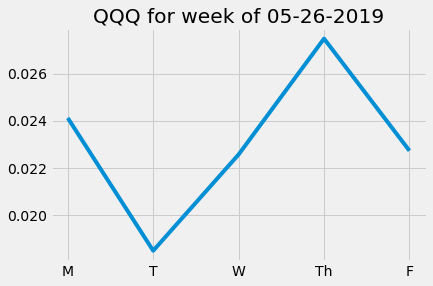

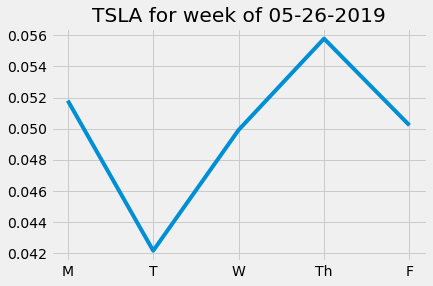

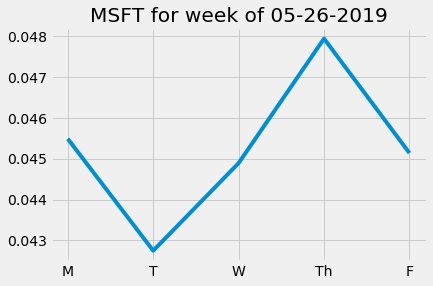

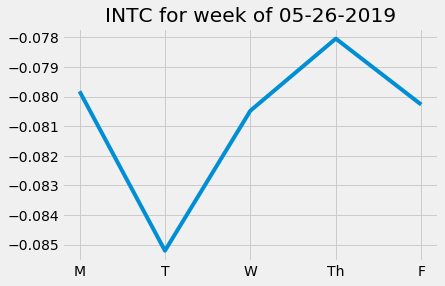

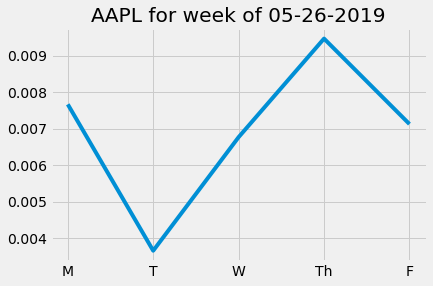

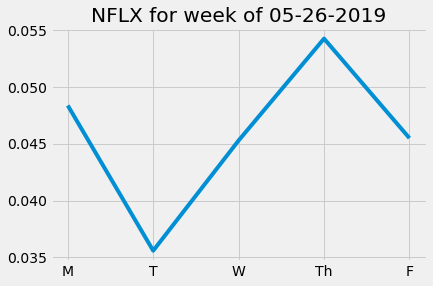

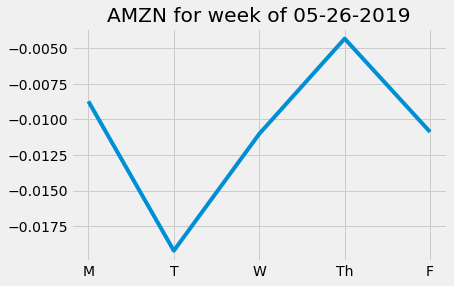

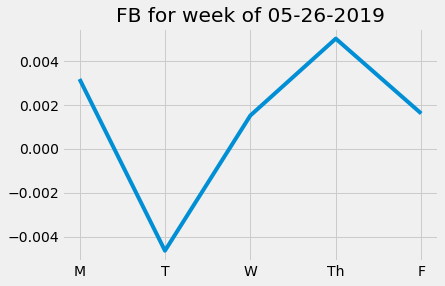

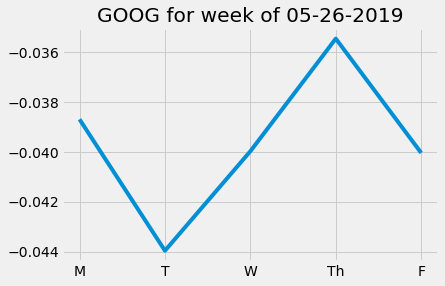

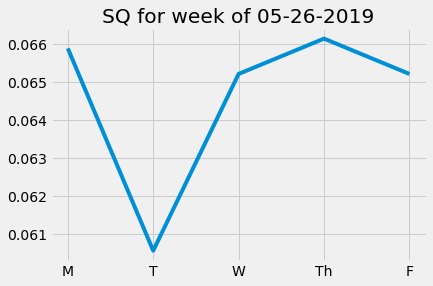

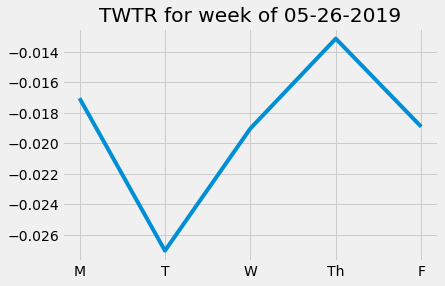

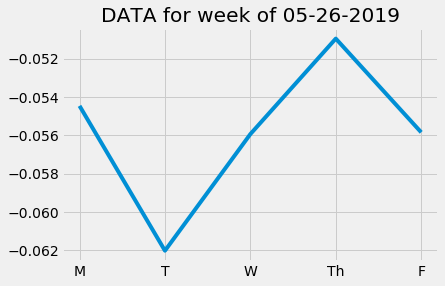

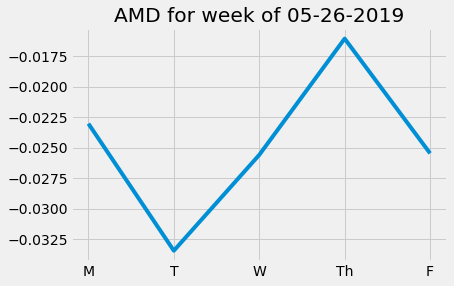

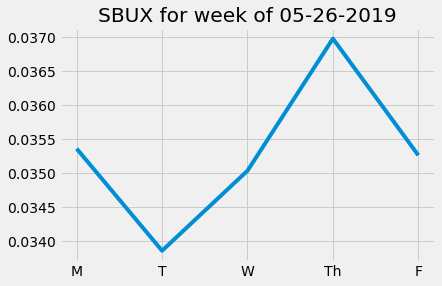

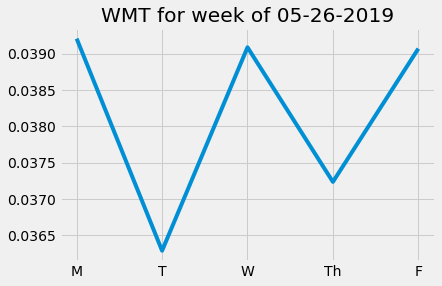

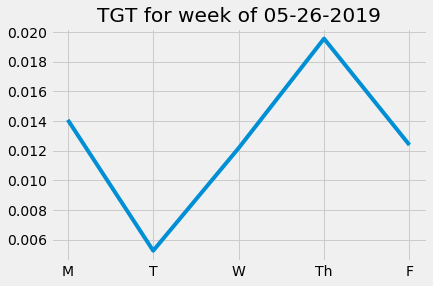

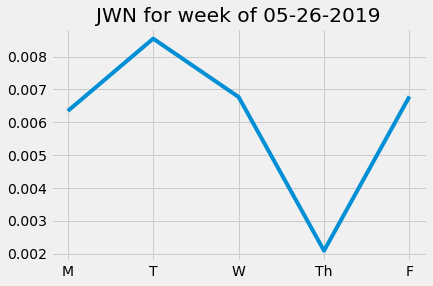

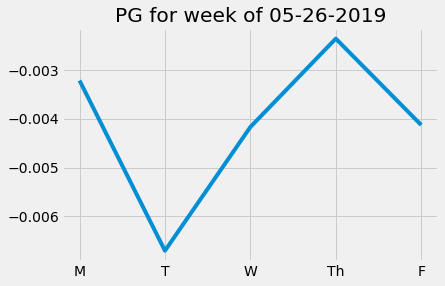

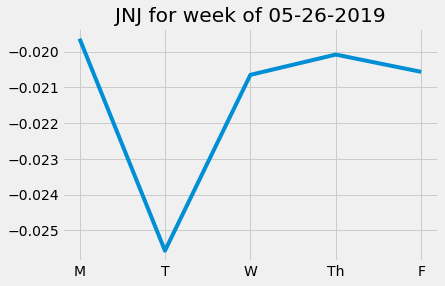

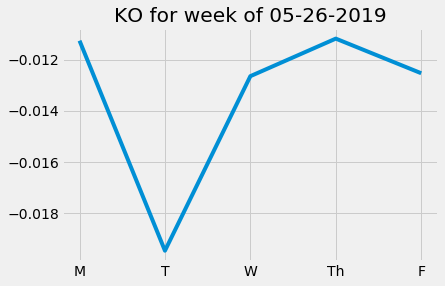

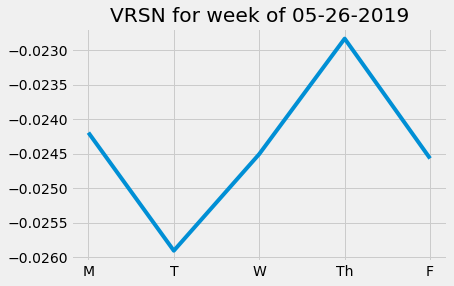

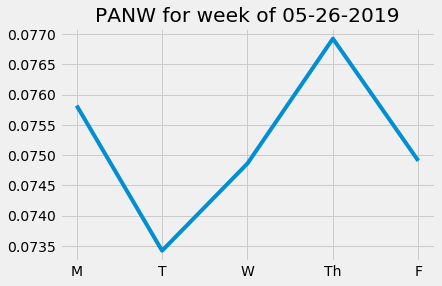

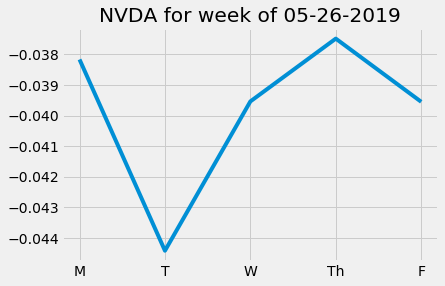

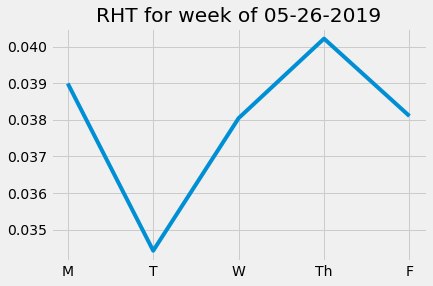

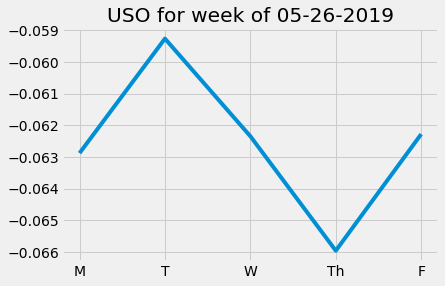

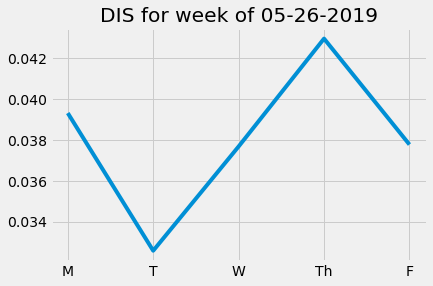

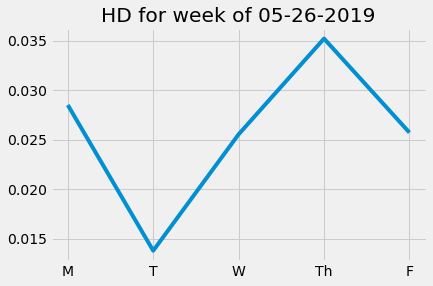

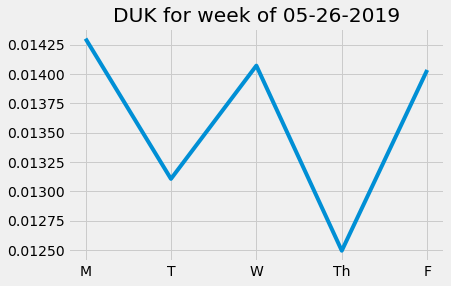

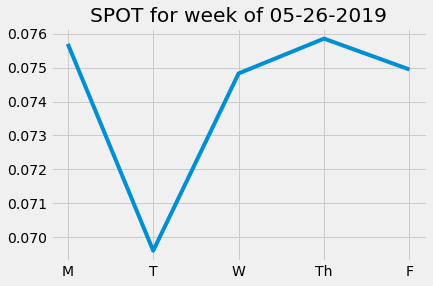

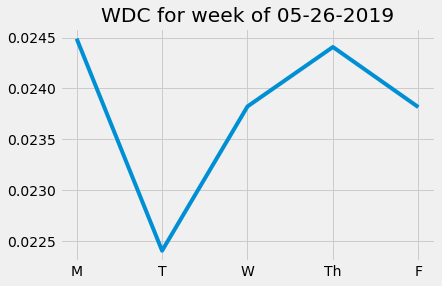

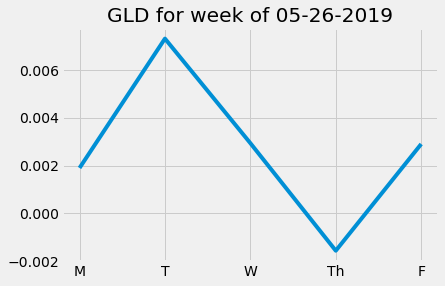

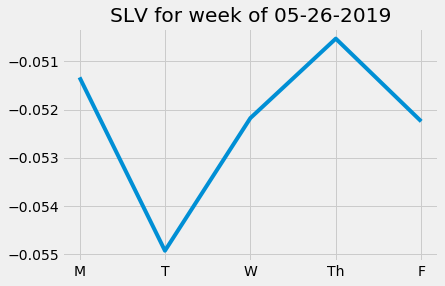

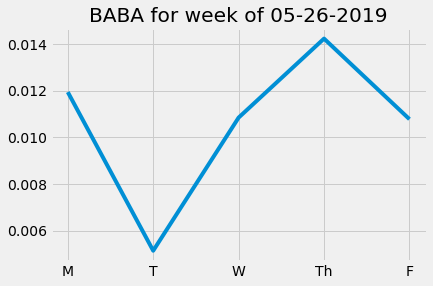

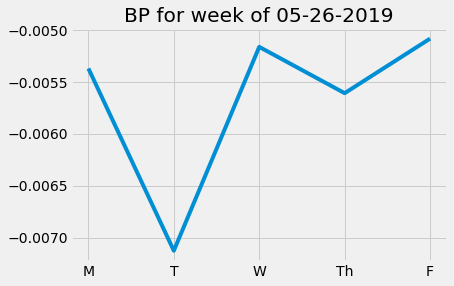

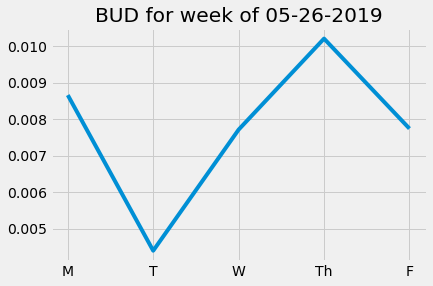

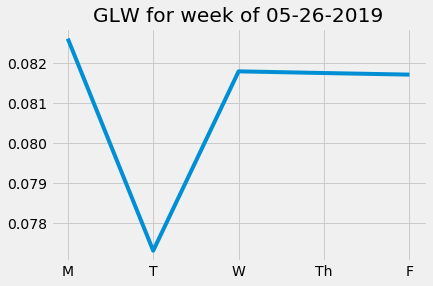

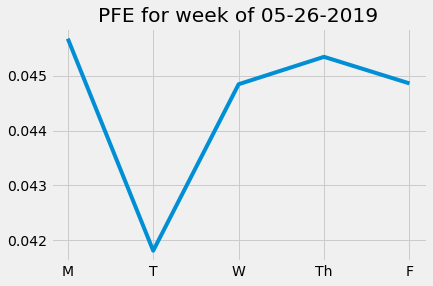

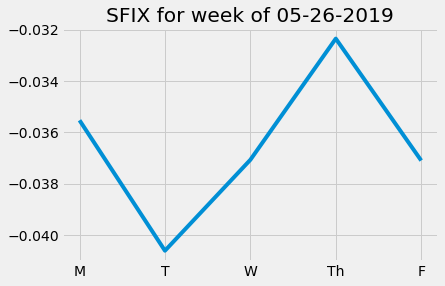

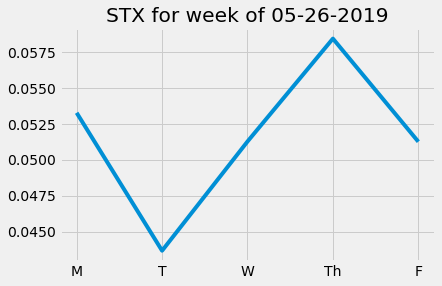

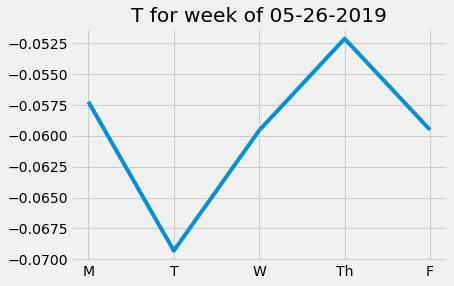

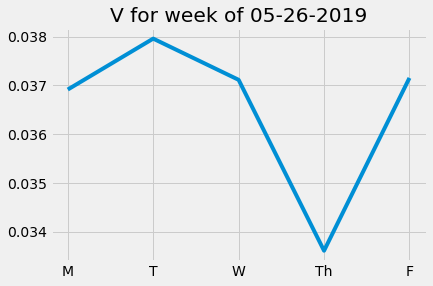

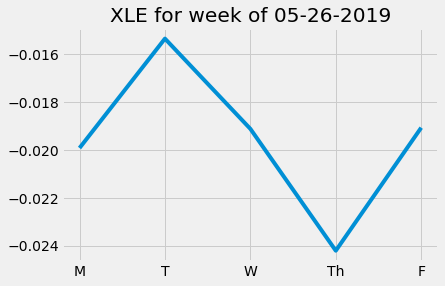

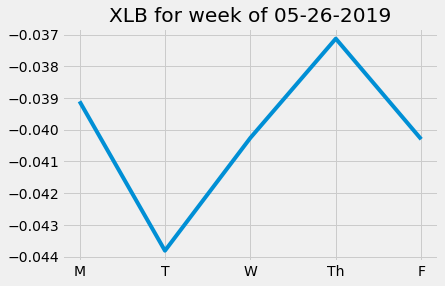

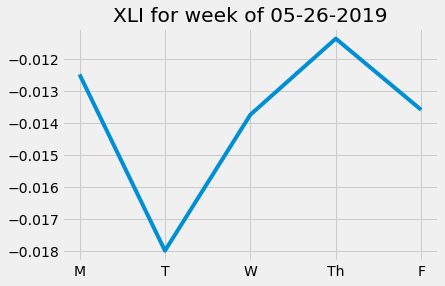

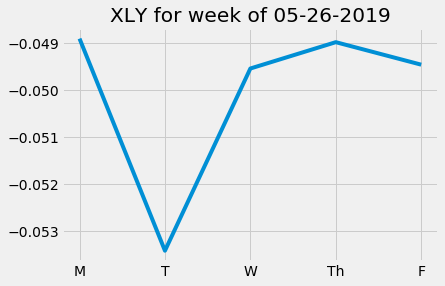

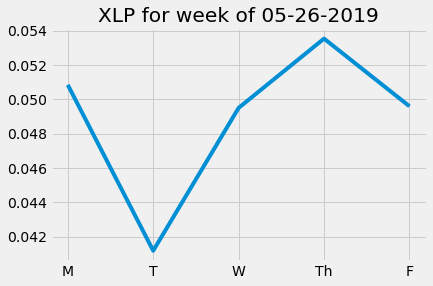

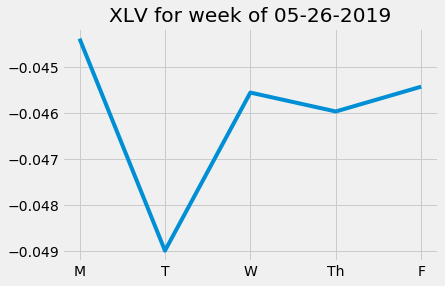

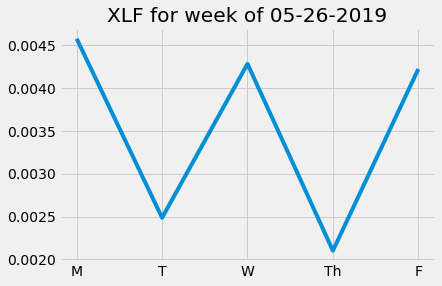

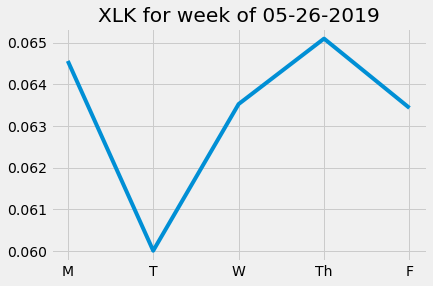

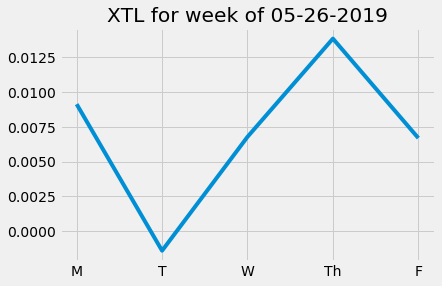

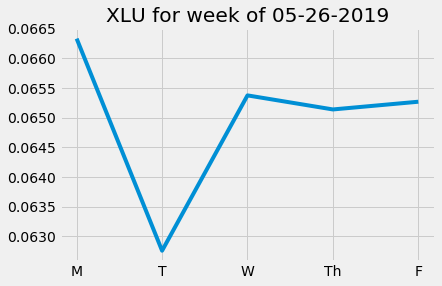

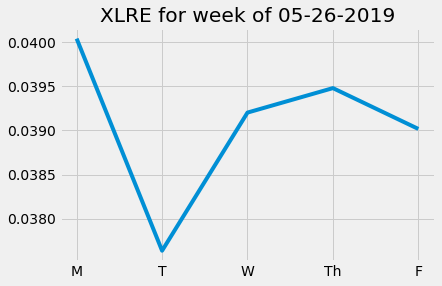

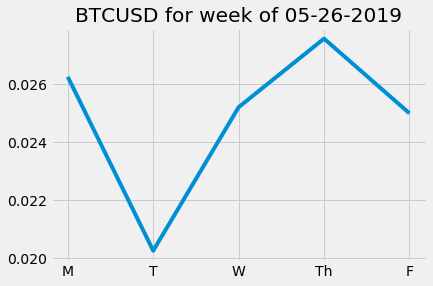

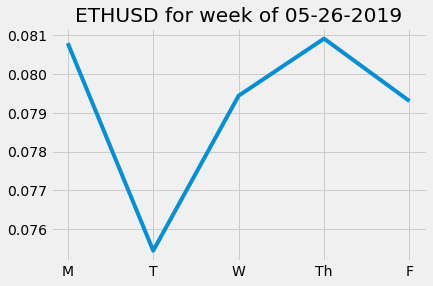

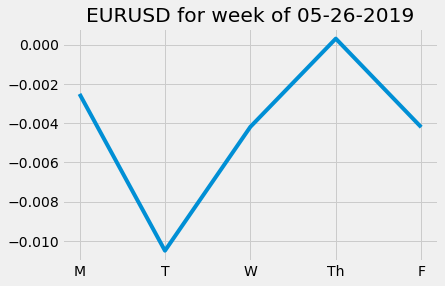

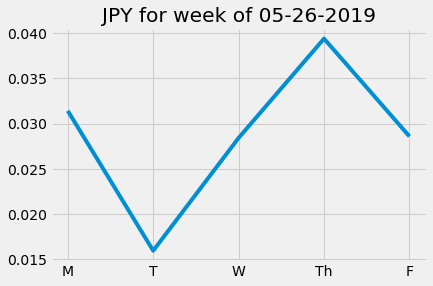

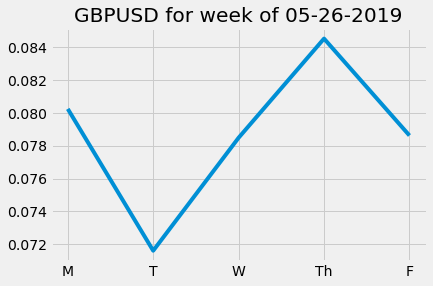

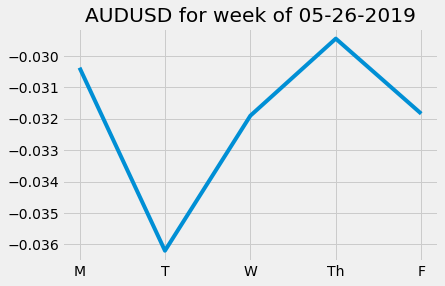

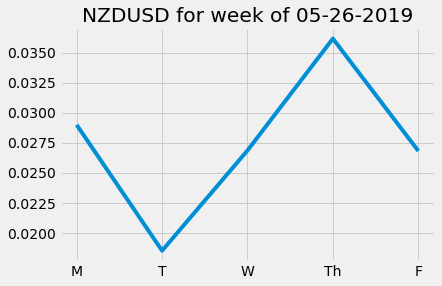

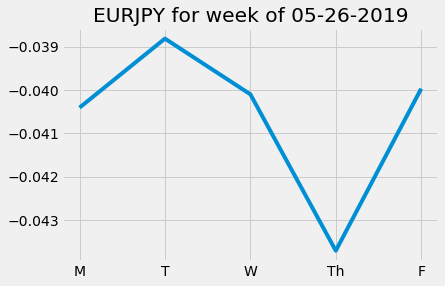

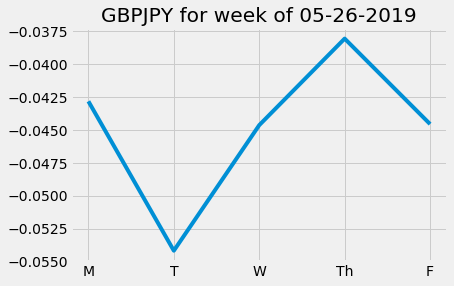

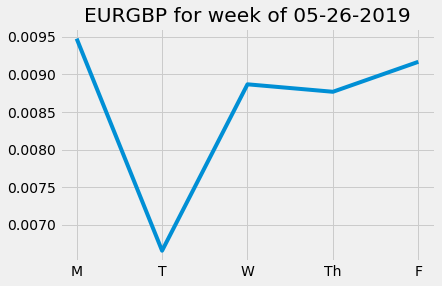

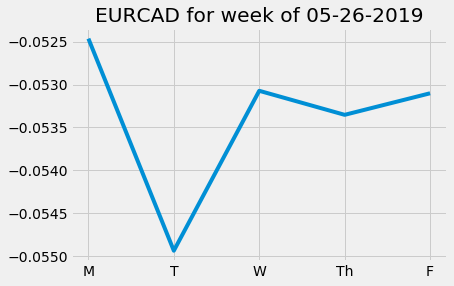

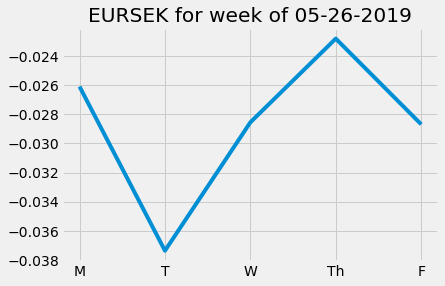

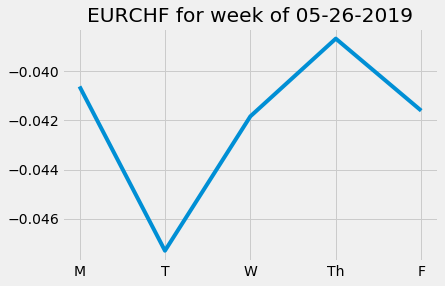

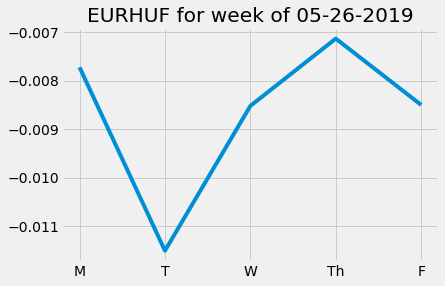

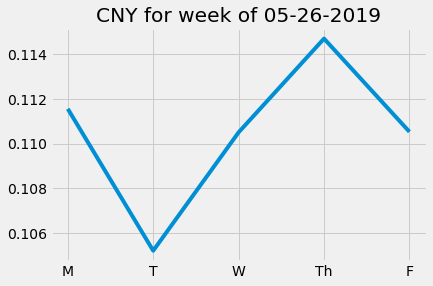

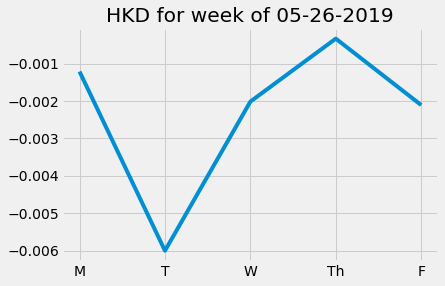

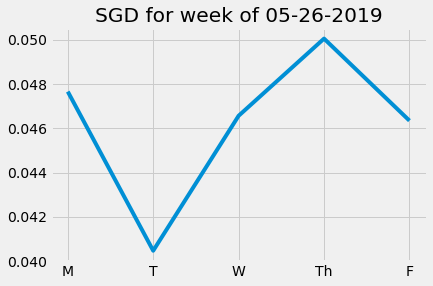

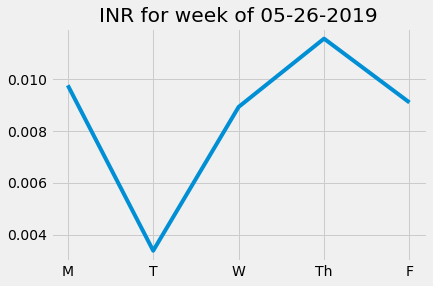

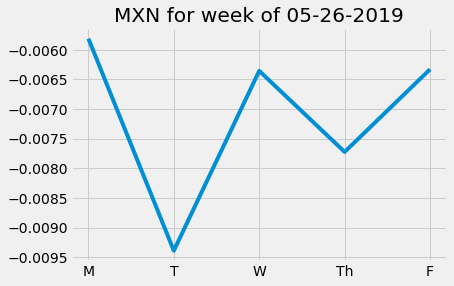

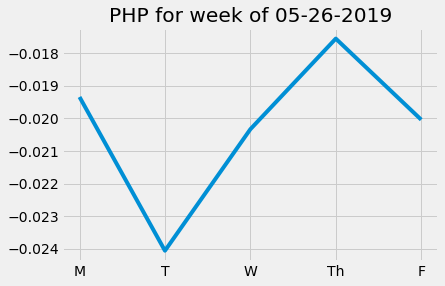

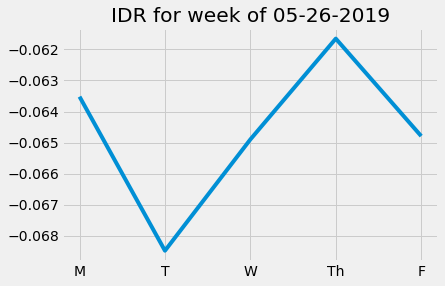

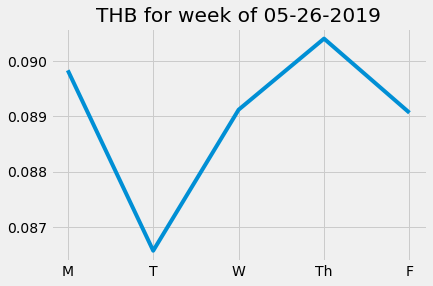

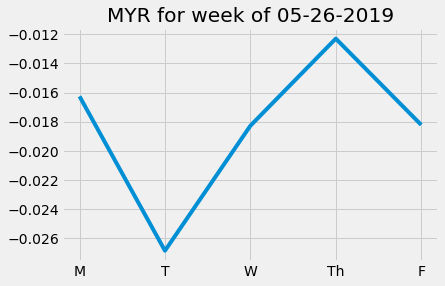

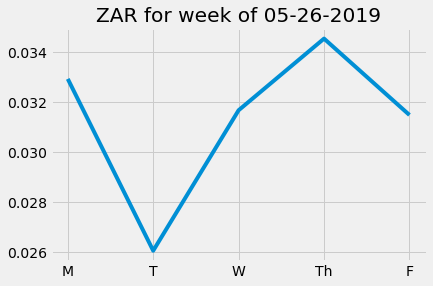

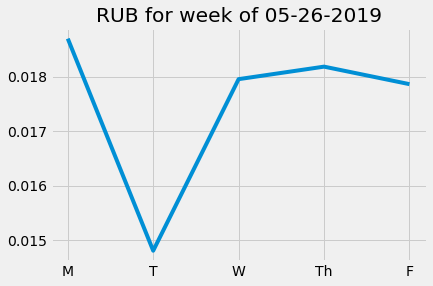

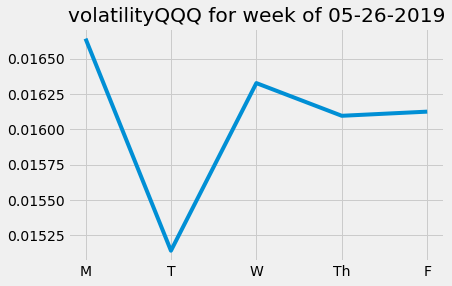

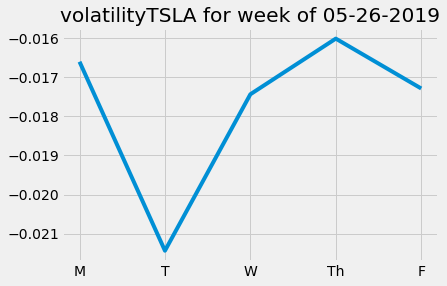

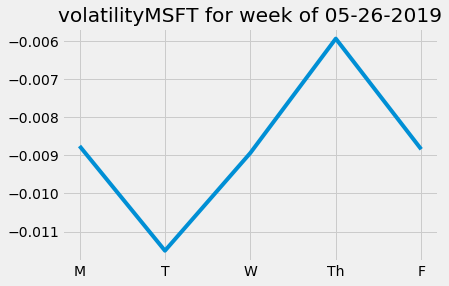

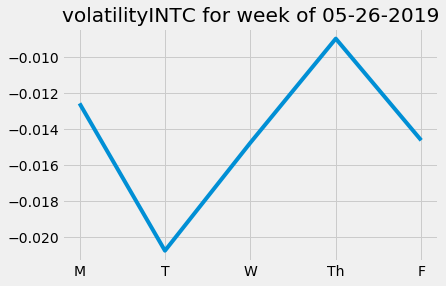

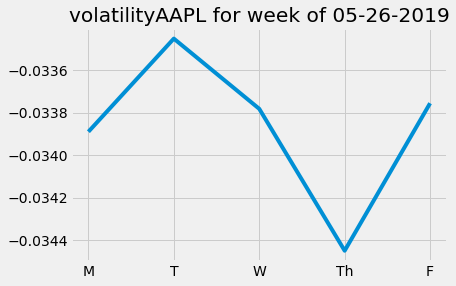

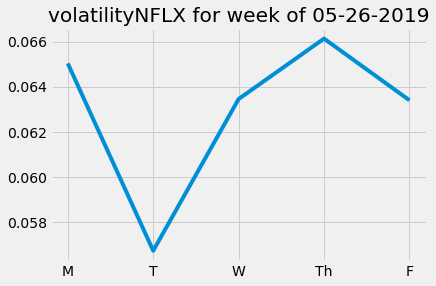

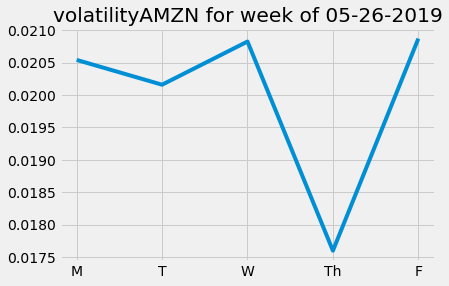

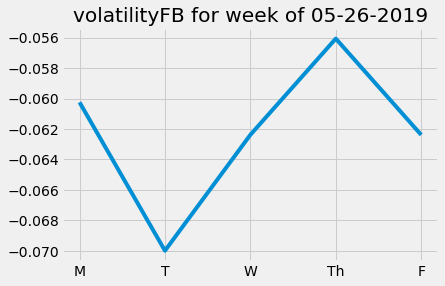

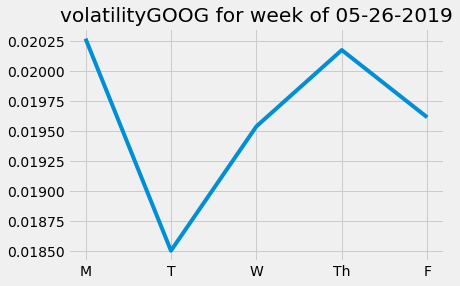

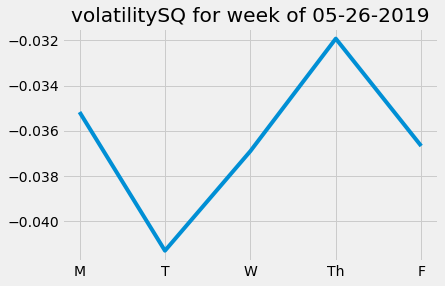

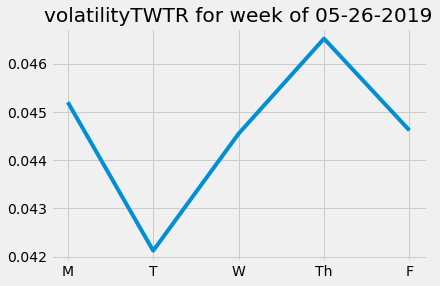

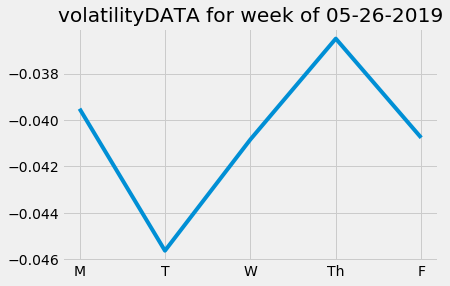

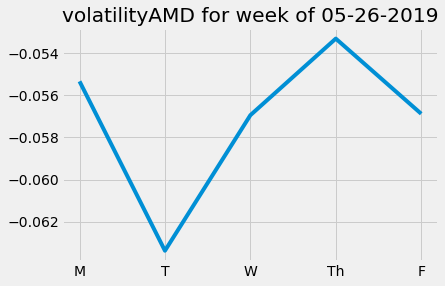

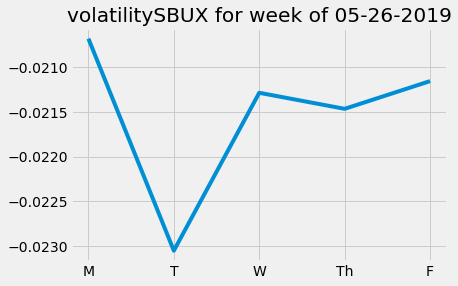

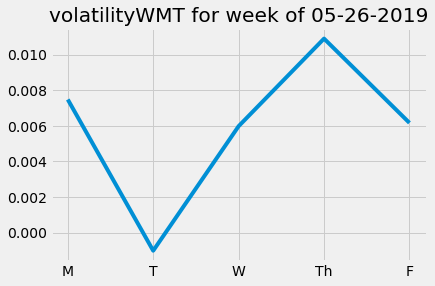

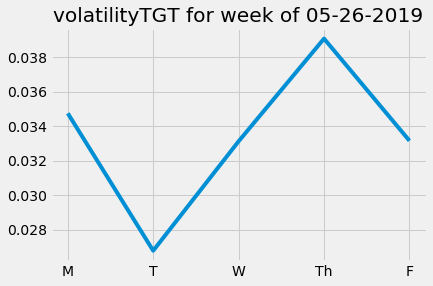

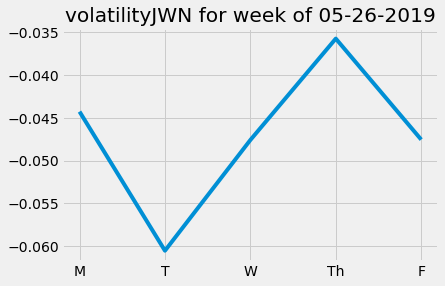

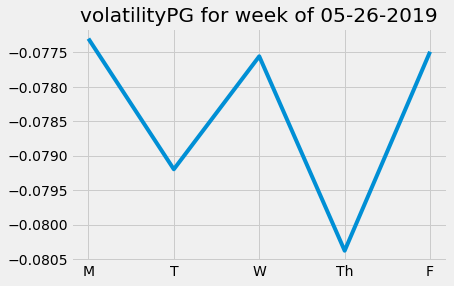

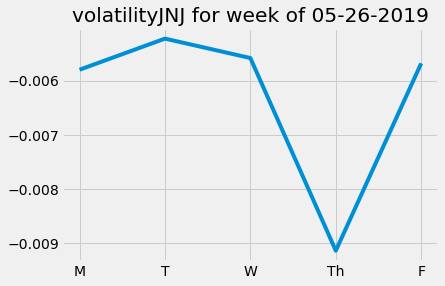

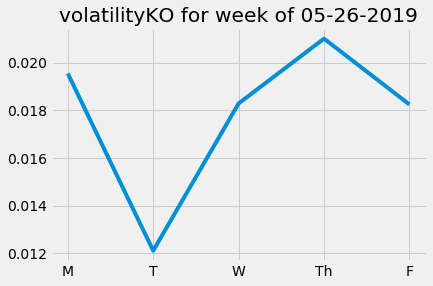

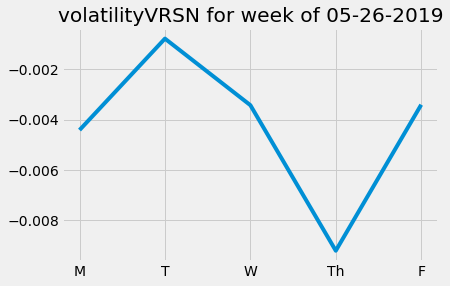

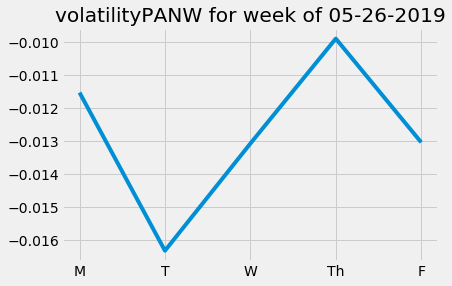

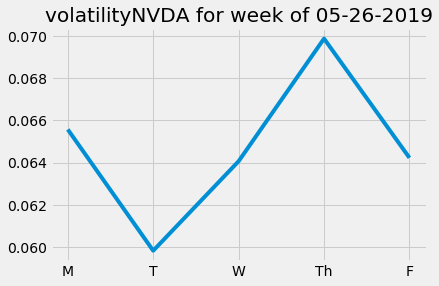

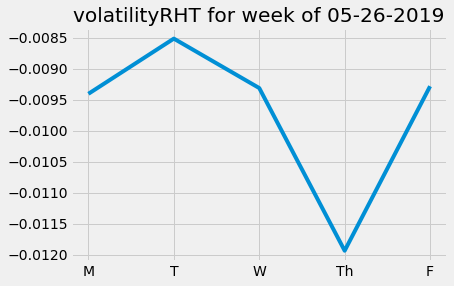

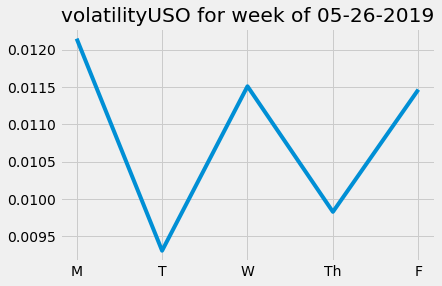

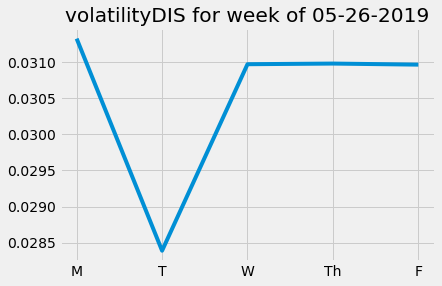

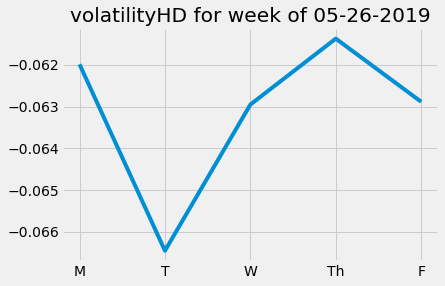

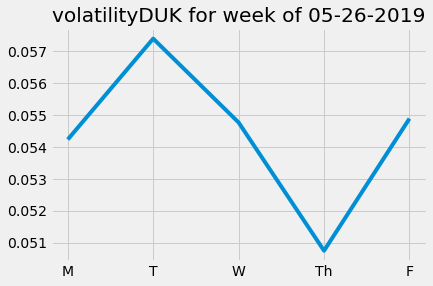

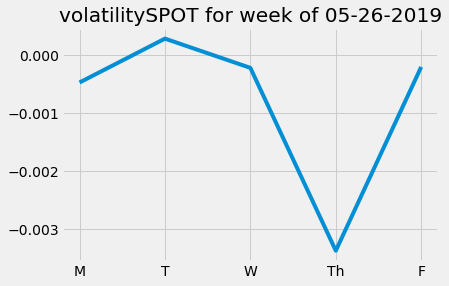

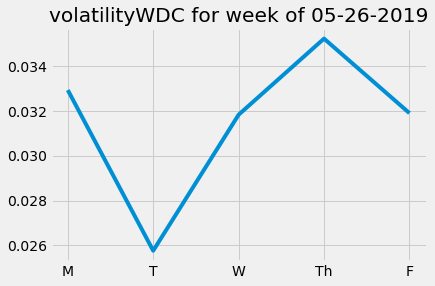

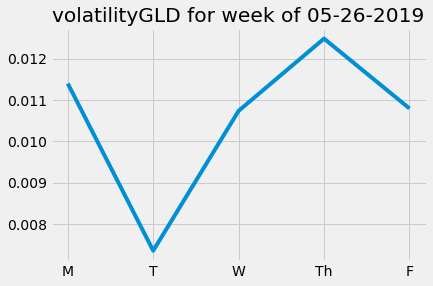

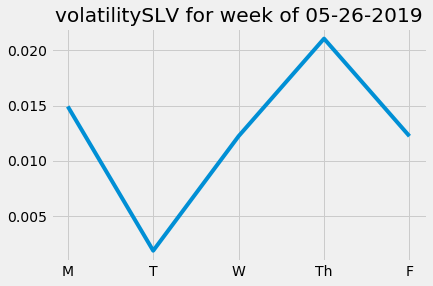

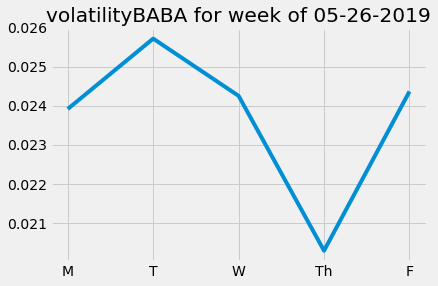

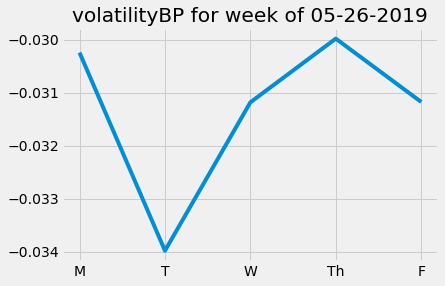

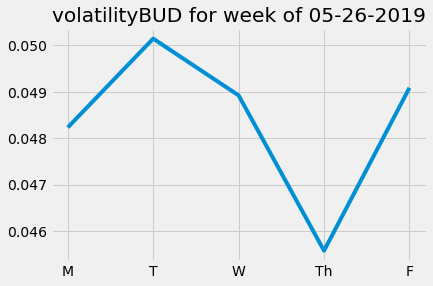

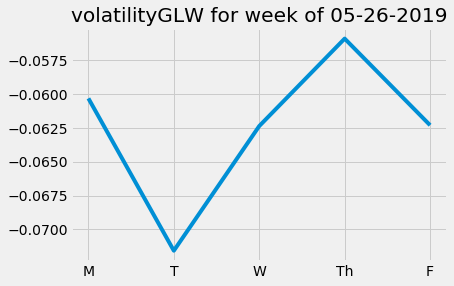

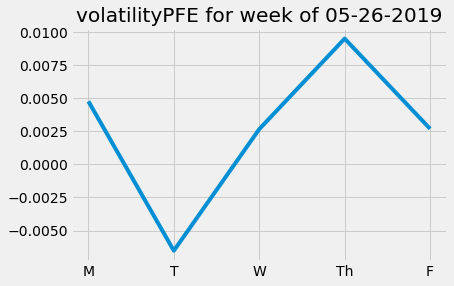

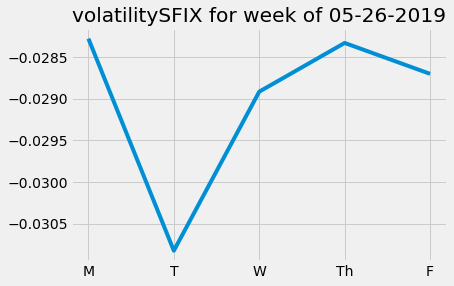

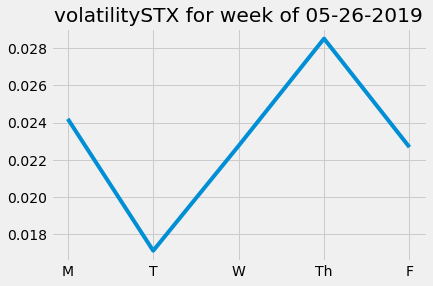

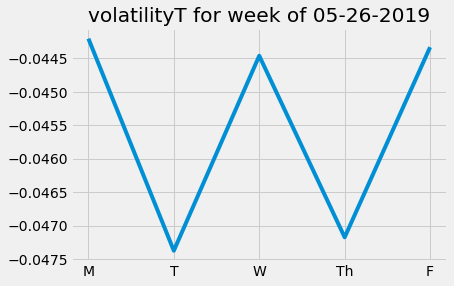

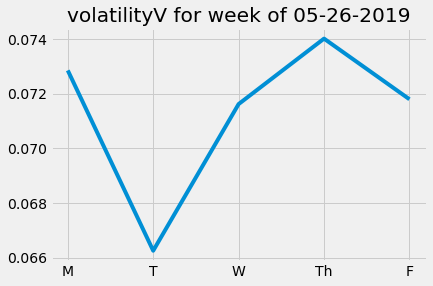

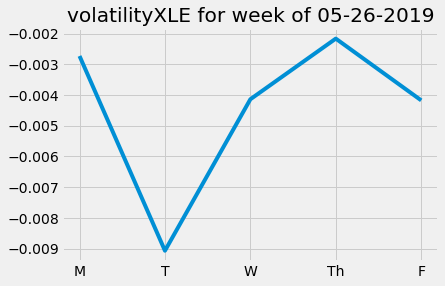

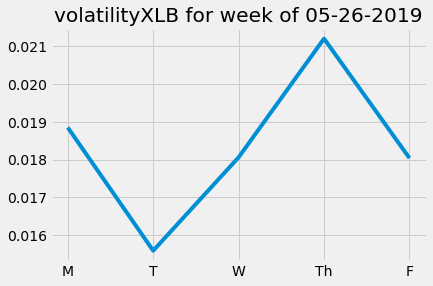

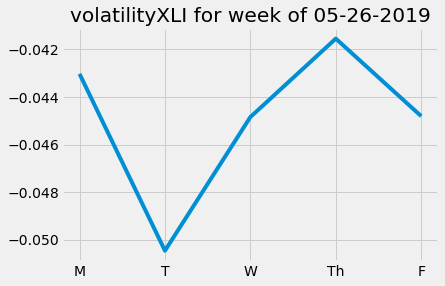

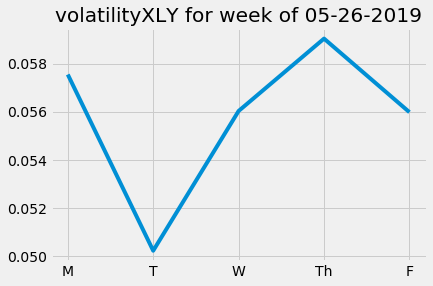

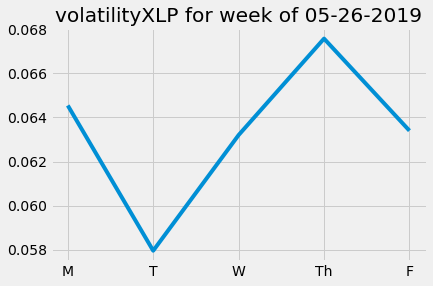

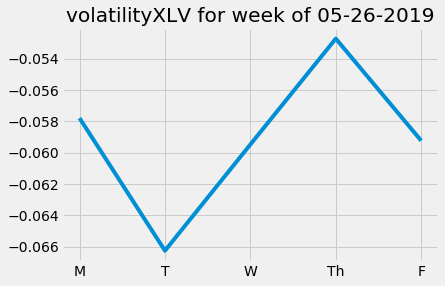

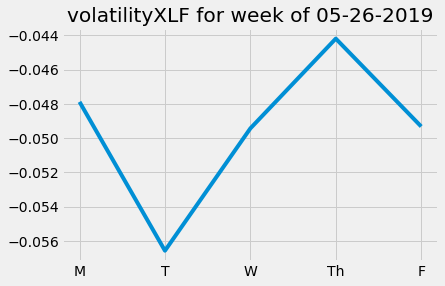

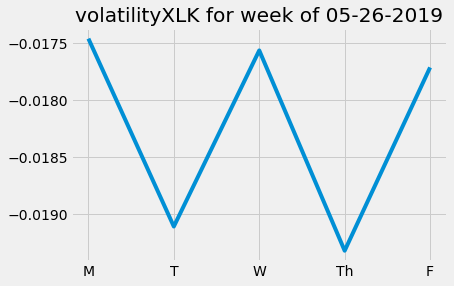

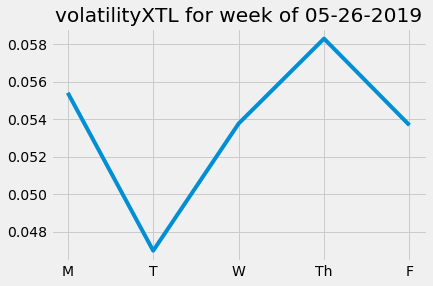

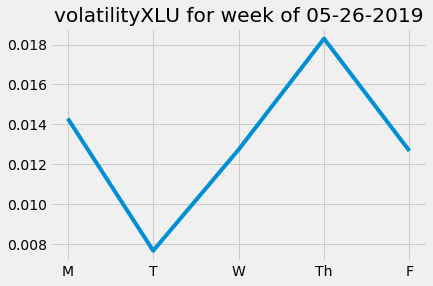

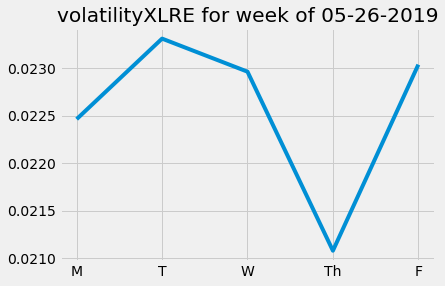

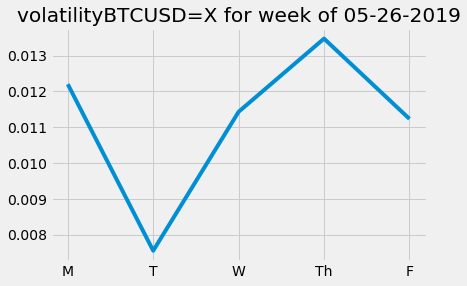

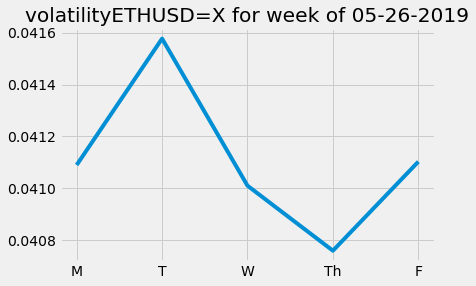

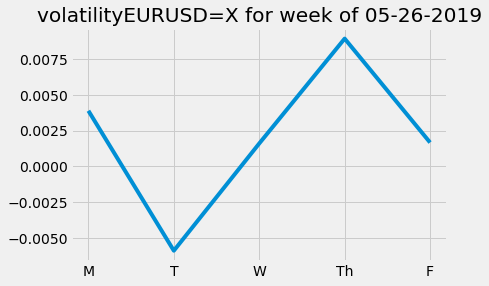

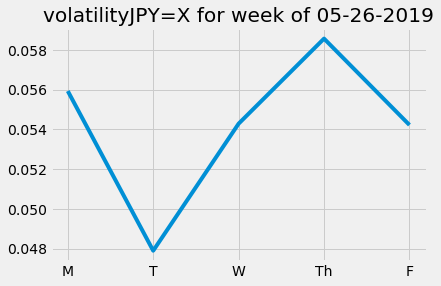

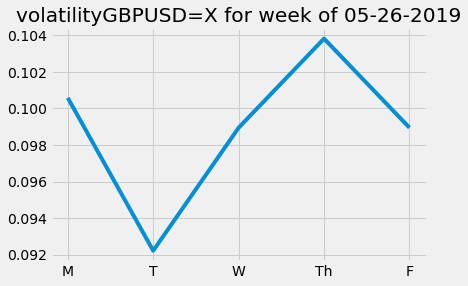

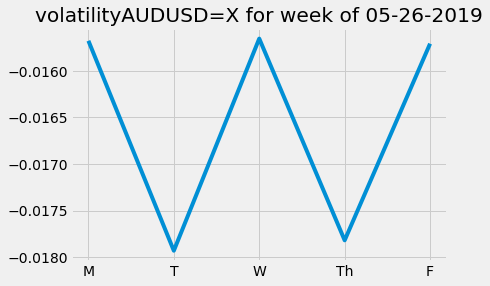

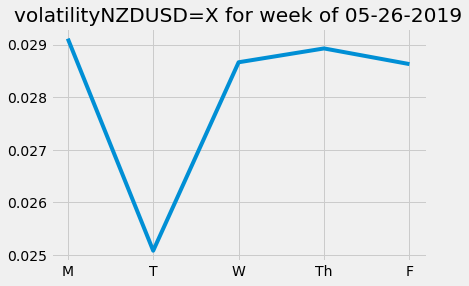

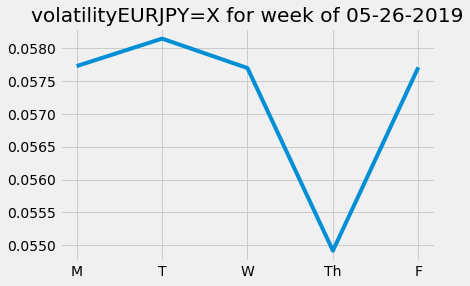

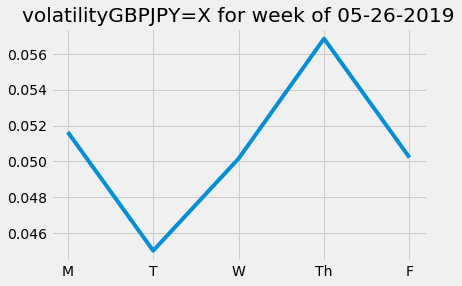

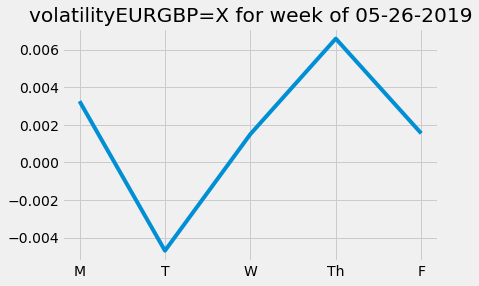

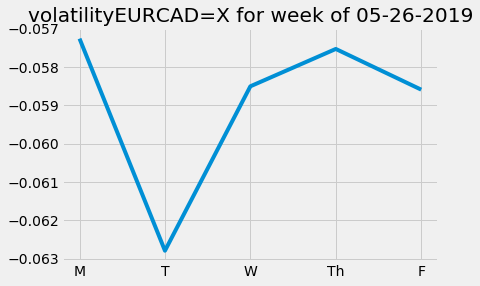

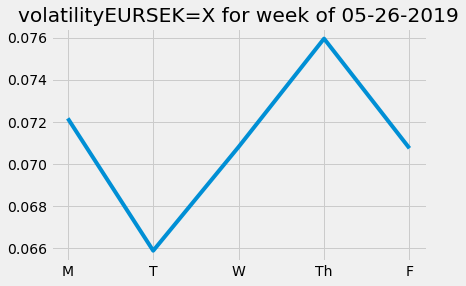

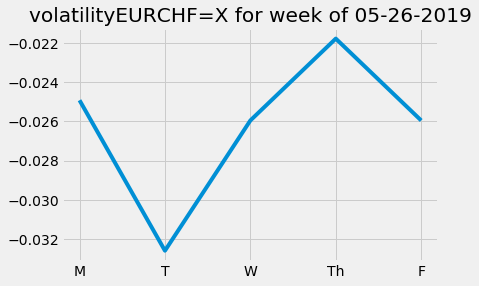

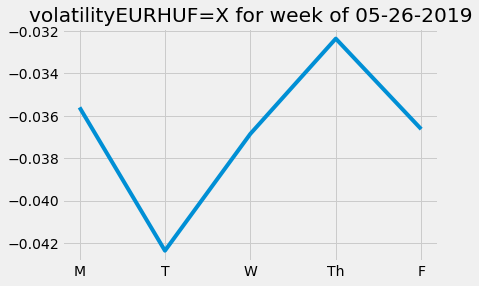

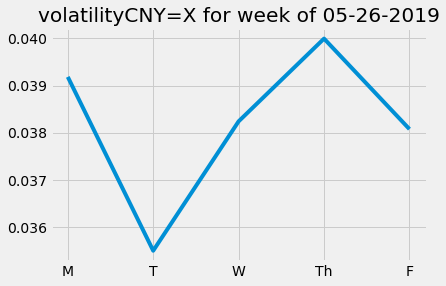

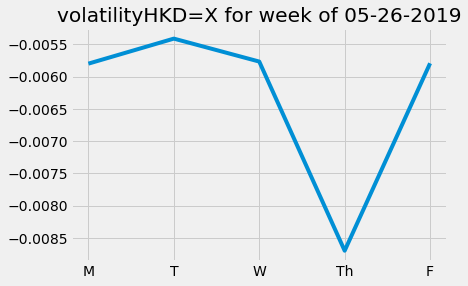

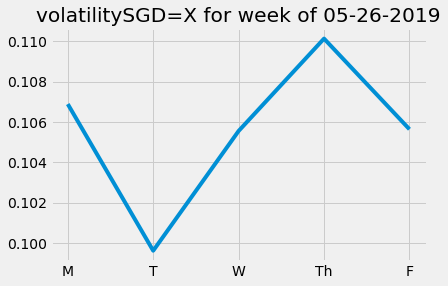

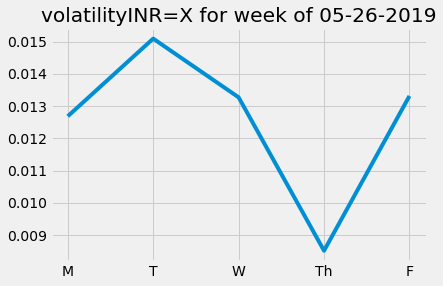

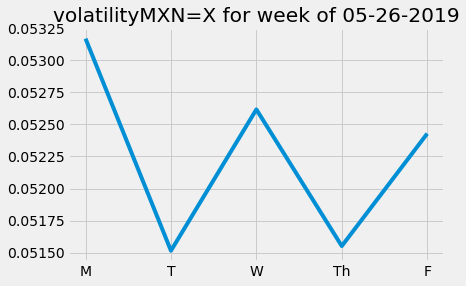

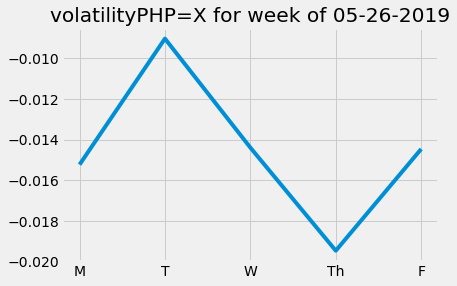

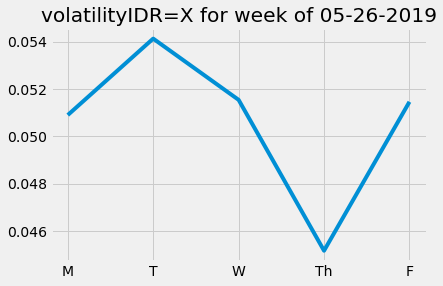

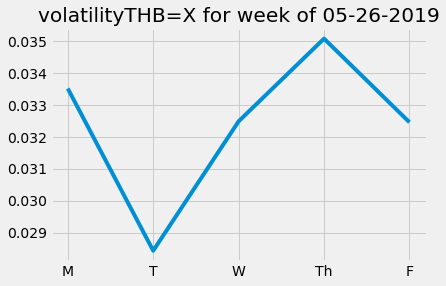

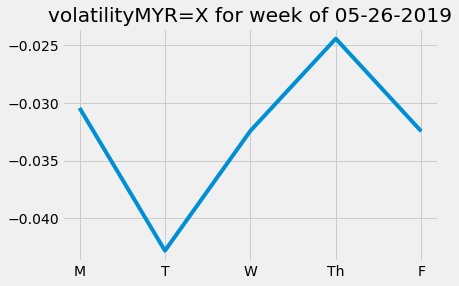

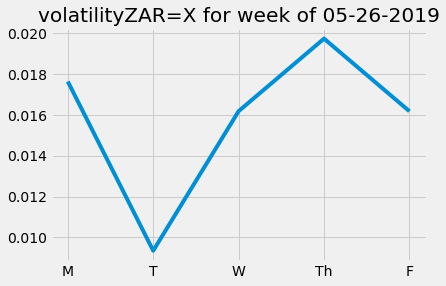

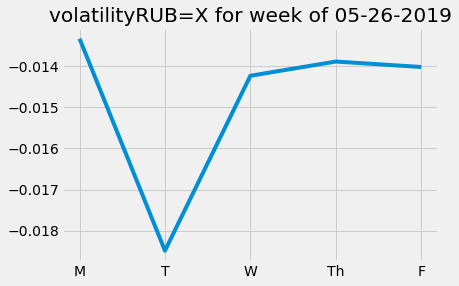

In [34]:
for t in list(ticker_lookup.keys()):
    plt.style.use('fivethirtyeight')
    plt.title(str(t)+" for week of "+"05-26-2019")
    plt.plot([i[ticker_lookup[t]] for i in best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))])
    plt.xticks(np.arange(5), ('M', 'T', 'W', 'Th', 'F'))
    if "volatility" in t:
        plt.savefig('../reports/'+t.split("volatility")[1]+'_volatility_prediction.png')
    else:
        plt.savefig('../reports/'+t+'_prediction.png')
    plt.show()

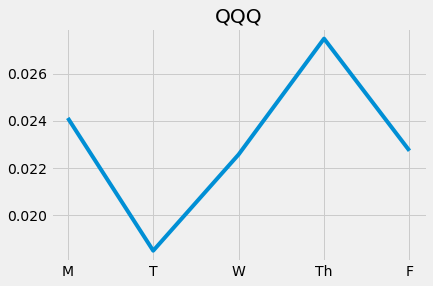

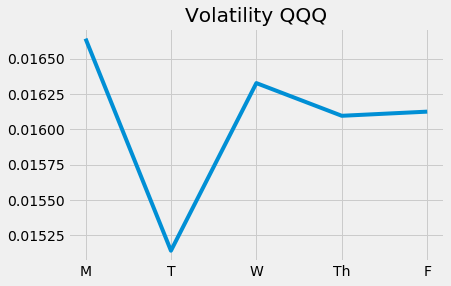

In [35]:
t = "QQQ"
plt.style.use('fivethirtyeight')
plt.title(t)
plt.plot([i[ticker_lookup[t]] for i in best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))])
plt.xticks(np.arange(5), ('M', 'T', 'W', 'Th', 'F'))
plt.show()

plt.title("Volatility "+t)
plt.plot([i[ticker_lookup["volatility"+t]] for i in best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))])
plt.xticks(np.arange(5), ('M', 'T', 'W', 'Th', 'F'))
plt.show()

In [36]:
f = open("instructions.txt", "w")
day_lookup = dict(enumerate(["M", "T", "W", "Th", "F"]))
strategy = {}
strategy["LONG"] = {"BUY" : {"M":{}, "T":{}, "W":{}, "Th":{}, "F":{}}, "SELL": {"M":{}, "T":{}, "W":{}, "Th":{}, "F":{}}}
strategy["SHORT"] = {"BUY" : {"M":{}, "T":{}, "W":{}, "Th":{}, "F":{}}, "SELL": {"M":{}, "T":{}, "W":{}, "Th":{}, "F":{}}}
tu = []
for t in list(ticker_lookup.keys()):
    week = [i[ticker_lookup[t]] for i in best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))]
    week_min = min(week)
    week_max = max(week)
    max_index = [i for i, v in enumerate(week) if v == week_max][0]
    min_index = [i for i, v in enumerate(week) if v == week_min][0]
    if min_index > max_index:
        print("LONG", t, "BUY ON", day_lookup[max_index], "SELL ON", day_lookup[min_index])
        f.write("LONG "+str(t)+" BUY ON "+str(day_lookup[max_index])+" SELL ON "+str(day_lookup[min_index])+'\n')
        strategy["LONG"]["BUY"][day_lookup[max_index]][t] = {"SELL" : day_lookup[min_index]}
        tu.append((0, t, max_index, min_index))
    else:
        print("SHORT", t, "SELL ON", day_lookup[min_index], "BUY ON", day_lookup[max_index])
        f.write("SHORT "+str(t)+" SELL ON "+str(day_lookup[min_index])+" BUY ON "+str(day_lookup[max_index])+'\n')
        strategy["SHORT"]["SELL"][day_lookup[min_index]][t] = {"BUY" : day_lookup[max_index]}
        tu.append((1, t, max_index, min_index))
        
f.close()

SHORT QQQ SELL ON T BUY ON Th
SHORT TSLA SELL ON T BUY ON Th
SHORT MSFT SELL ON T BUY ON Th
SHORT INTC SELL ON T BUY ON Th
SHORT AAPL SELL ON T BUY ON Th
SHORT NFLX SELL ON T BUY ON Th
SHORT AMZN SELL ON T BUY ON Th
SHORT FB SELL ON T BUY ON Th
SHORT GOOG SELL ON T BUY ON Th
SHORT SQ SELL ON T BUY ON Th
SHORT TWTR SELL ON T BUY ON Th
SHORT DATA SELL ON T BUY ON Th
SHORT AMD SELL ON T BUY ON Th
SHORT SBUX SELL ON T BUY ON Th
LONG WMT BUY ON M SELL ON T
SHORT TGT SELL ON T BUY ON Th
LONG JWN BUY ON T SELL ON Th
SHORT PG SELL ON T BUY ON Th
LONG JNJ BUY ON M SELL ON T
SHORT KO SELL ON T BUY ON Th
SHORT VRSN SELL ON T BUY ON Th
SHORT PANW SELL ON T BUY ON Th
SHORT NVDA SELL ON T BUY ON Th
SHORT RHT SELL ON T BUY ON Th
LONG USO BUY ON T SELL ON Th
SHORT DIS SELL ON T BUY ON Th
SHORT HD SELL ON T BUY ON Th
LONG DUK BUY ON M SELL ON Th
SHORT SPOT SELL ON T BUY ON Th
LONG WDC BUY ON M SELL ON T
LONG GLD BUY ON T SELL ON Th
SHORT SLV SELL ON T BUY ON Th
SHORT BABA SELL ON T BUY ON Th
SHORT BP S